# 类比实验
- 32个受试者，按比例划分数据集，进行八折交叉验证
- 把测试受试者随机选择一个训练好的模型（不选择Wasserstein距离最近的模型）作为对比实验
- 与单受试者模型做对比，期望结果，准确率相差不多或比单受试者模型准确率略低
- 与所有受试者公用一个模型做对比，期望结果，比所有受试者公用模型准确率高很多

In [1]:
# 每次新建项目，先到运行：

# import zipfile
# import os
# def un_zip(file_name):
#     """unzip zip file"""
#     zip_file = zipfile.ZipFile(file_name)
#     for names in zip_file.namelist():
#         zip_file.extract(names,'work/')
#     zip_file.close()

# un_zip('/home/aistudio/data/data77240/pyeeg-master.zip')

# if os.path.isdir("work/data"):
#     pass
# else:
#     os.mkdir("work/data")

"""
每次运行环境，到终端执行如下两行命令（然后重启内核）：
cd ./work/pyeeg-master
python setup.py install
"""

'\n每次运行环境，到终端执行如下两行命令（然后重启内核）：\ncd ./work/pyeeg-master\npython setup.py install\n'

In [2]:
#加载飞桨、Numpy和相关类库
import numpy as np
#import pyeeg as pe

import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
#from paddle.fluid.dygraph import Linear
#import numpy as np
import os
import random

import paddle.fluid.optimizer as opt
#from paddle.fluid.dygraph.nn import Linear
from paddle.fluid.dygraph.nn import Conv2D, Pool2D, Linear
from PIL import Image
import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance

In [3]:
#加载一个受试者
def De_baseline(sub):
    dir='/home/aistudio/data/data57707/1280x258050(32x8064+2).npy'
    data=np.load(dir)
    subData = data[sub * 40 : (sub + 1) * 40]
    subData[: , -2:] = np.where(subData[: , -2:] >= 5 , 1 , 0)
    return subData

In [4]:
#数据集切60片，基线单独返回
def Data_set_partition(subData):
    features = subData[:,:-2]
    labels = subData[:,-2:]
    features = features.reshape(40,32,-1)
    baseline = features[:,:,:384]
    features = features[:,:,384:]
    
    dataList = []
    for i in range(40):
        for j in range(60):
            dataList.append(np.append(features[i][ : , j * 128 : (j + 1) * 128].reshape(-1) , labels[i]))

    dataList = np.array(dataList)

    return dataList, baseline

In [5]:
#特征提取
def feature_extraction(trainData, baseline):

    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]    
    window_size = 128 #Averaging band power of 1 sec
    step_size = 128 #Each 1 sec update once
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData[:,:-2]
    labels = trainData[:,-2:]
    features = features.reshape(features.shape[0],32,128)

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
            ###################################################################################
        channel_features += list(labels[i])    #添加标签
        newData.append(channel_features)
    trainData = np.array(newData)

    #计算频域基线
    features = baseline

    newData=[]
    for i in range(features.shape[0]):    #电影数
        channel_features=[]
        for k in range(3):
            baseline_feature = []
            for j in range(32):
                X = features[i][j][k * 128 : (k + 1) * 128]
                Y = pe.bin_power(X, band, sample_rate)
                baseline_feature += list(Y[0])
            channel_features.append(baseline_feature)    #求基线的均值还是均值的基线？
        newData.append(np.array(channel_features).mean(axis = 0))
    newData = np.array(newData)

    for i in range(40):
        trainData[i * 60 : (i + 1) * 60 , : 160] -= newData[i]

    return trainData

In [6]:
# AllSubFreq = []    #保存所有受试者的频域特征32*2400*160(不含标签)
# for sub in range(32):
#     SubData = De_baseline(sub)
#     dataList, baseline = Data_set_partition(SubData)
#     trainData = feature_extraction(dataList, baseline)
#     AllSubFreq.append(trainData)
# AllSubFreq = np.array(AllSubFreq)
# print(AllSubFreq.shape)
# np.save("work/data/with_label_DE_baseline_AllSubFreq",AllSubFreq)

In [7]:
# #计算KL散度
# import numpy as np
# import scipy.stats

# # 利用scipy API进行计算
# # scipy计算函数可以处理非归一化情况，因此这里使用
# # scipy.stats.entropy(x, y)或scipy.stats.entropy(px, py)均可
# KL = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         KL[i][j] = scipy.stats.entropy(x, y)
# print(KL)
# np.save("work/data/KL_AllSubFreq.npy",KL)

In [8]:
# #计算JS散度

# import numpy as np
# import scipy.stats

# def JS_divergence(p,q):
#     M=(p+q)/2
#     return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

# JS = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         JS[i][j] = JS_divergence(x, y)
# np.set_printoptions(threshold = 1e6)
# print(JS)
# np.save("work/data/JS_AllSubFreq.npy",JS)


In [9]:
# #计算Wasserstein距离
# from scipy.stats import wasserstein_distance
# # x0 = wasserstein_distance([0, 1, 3], [0, 1, 3])		#相同的分布，分布的差异为0
# # x1 = wasserstein_distance([3, 1, 0], [0, 1, 3])		#相同分布，但元素顺序打乱，分布的差异值仍然为0
# # x2 = wasserstein_distance([0, 1, 2], [0, 1, 3])     #分布中只有部分值相同，分布的差异值仍然为0.3
# # x3 = wasserstein_distance([4, 5, 6], [0, 1, 3])     #分布完全不同，分布的差异值为3.6

# AllSubFreq = np.load("work/data/DE_baseline_AllSubFreq.npy")
# AllSubFreq = AllSubFreq.reshape((32,-1))
# print(AllSubFreq.shape)


# Wasserstein = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         Wasserstein[i][j] = wasserstein_distance(x, y)
# print(Wasserstein)
# np.save("work/data/Wasserstein_AllSubFreq.npy",Wasserstein)

In [10]:
#哈夫曼思想聚类
def huffman(indexList):
    """
    取 indexNpArray 中的受试者
    """
    KL = np.load("work/data/Wasserstein_AllSubFreq.npy")
    indexNpArray = np.array(indexList)
    
    KLmax = np.max(KL)

    for i in range(KL.shape[0]):
        KL[i][i] = KLmax + 1

    classList = []
    subScript = list(indexNpArray)

    while len(subScript) :
        argMin = np.argmin(KL)
        row = argMin//KL.shape[0]
        col = argMin % KL.shape[0]
        
        KL[row][col] = KLmax + 1
        KL[col][row] = KLmax + 1
        if (row not in indexList) or (col not in indexList) :
            continue
        
        if (row in subScript) and (col in subScript) :
            classList.append([row, col])
            subScript.remove(row)
            subScript.remove(col)
        else :
            for i in range(len(classList)):
                    if (row in classList[i]) and (col in subScript):
                        classList[i].append(col)
                        subScript.remove(col)
                        break
                    elif (col in classList[i]) and (row in subScript):
                        classList[i].append(row)
                        subScript.remove(row)
                        break
    return classList

In [11]:
# def Gaussian_normalization(trainData, testData):
#     """高斯归一化"""

#     #训练样本归一化
#     feature=trainData[:,:-2]
#     mean=feature.mean(axis=0)
#     std=feature.std(axis=0)
#     feature-=mean
#     feature/=std
#     trainData[:,:-2] = feature

#     #测试样本归一化
#     feature=testData[:,:-2]
#     feature-=mean
#     feature/=std
#     testData[:,:-2] = feature

#     return trainData, testData

# 检查模型训练过程，识别潜在训练问题

使用飞桨动态图可以方便的查看和调试训练的执行过程。在网络定义的``Forward``函数中，可以打印每一层输入输出的尺寸，以及每层网络的参数。通过查看这些信息，不仅可以更好地理解训练的执行过程，还可以发现潜在问题，或者启发继续优化的思路。

在下述程序中，使用``check_shape``变量控制是否打印“尺寸”，验证网络结构是否正确。使用``check_content``变量控制是否打印“内容值”，验证数据分布是否合理。假如在训练中发现中间层的部分输出持续为0，说明该部分的网络结构设计存在问题，没有充分利用。

In [12]:
class continuous_CNN(dygraph.Layer):
    def __init__(self):
        super(continuous_CNN,self).__init__()

        self.conv1 = Conv2D(num_channels=4, num_filters=128, filter_size=5, stride=1, padding=0, act='relu')
        self.pool1 = Pool2D(pool_size=2, pool_stride=1, pool_type='max')
        self.conv2 = Conv2D(num_channels=128, num_filters=64, filter_size=5, stride=1, padding=0, act='relu')
        self.pool2 = Pool2D(pool_size=2, pool_stride=1, pool_type='max')

        self.fc1 = Linear(input_dim=160, output_dim=320, act='relu')
        self.fc2 = Linear(input_dim=320, output_dim=640, act='relu')
        self.fc3 = Linear(input_dim=640, output_dim=1280, act='relu')
        self.fc4 = Linear(input_dim=1280, output_dim=640, act='relu')
        self.fc5 = Linear(input_dim=640, output_dim=640, act='relu')
        self.fc6 = Linear(input_dim=640, output_dim=320, act='relu')
        self.fc7 = Linear(input_dim=320, output_dim=160, act='relu')
        self.fc8 = Linear(input_dim=160, output_dim=2, act='softmax')

    def forward(self, x, label=None, check_shape=False, check_content=False):
    
        # x = self.conv1(x)
        # x = self.pool1(x)
        # x = self.conv2(x)
        # x = self.pool2(x)

        x = fluid.layers.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.fc7(x)
        x = self.fc8(x)


        # 选择是否打印神经网络每层的参数尺寸和输出尺寸，验证网络结构是否设置正确
        if check_shape:
            # 打印每层网络设置的超参数-卷积核尺寸，卷积步长，卷积padding，池化核尺寸
            print("\n########## print network layer's superparams ##############")
            print("conv1-- kernel_size:{}, padding:{}, stride:{}".format(self.conv1.weight.shape, self.conv1._padding, self.conv1._stride))
            print("conv2-- kernel_size:{}, padding:{}, stride:{}".format(self.conv2.weight.shape, self.conv2._padding, self.conv2._stride))
            print("pool1-- pool_type:{}, pool_size:{}, pool_stride:{}".format(self.pool1._pool_type, self.pool1._pool_size, self.pool1._pool_stride))
            print("pool2-- pool_type:{}, poo2_size:{}, pool_stride:{}".format(self.pool2._pool_type, self.pool2._pool_size, self.pool2._pool_stride))
            print("fc-- weight_size:{}, bias_size_{}, activation:{}".format(self.fc.weight.shape, self.fc.bias.shape, self.fc._act))
            
            # 打印每层的输出尺寸
            print("\n########## print shape of features of every layer ###############")
            print("inputs_shape: {}".format(inputs.shape))
            print("outputs1_shape: {}".format(outputs1.shape))
            print("outputs2_shape: {}".format(outputs2.shape))
            print("outputs3_shape: {}".format(outputs3.shape))
            print("outputs4_shape: {}".format(outputs4.shape))
            print("outputs5_shape: {}".format(outputs5.shape))
            
        # 选择是否打印训练过程中的参数和输出内容，可用于训练过程中的调试
        if check_content:
        # 打印卷积层的参数-卷积核权重，权重参数较多，此处只打印部分参数
            print("\n########## print convolution layer's kernel ###############")
            print("conv1 params -- kernel weights:", self.conv1.weight[0][0])
            print("conv2 params -- kernel weights:", self.conv2.weight[0][0])

            # 创建随机数，随机打印某一个通道的输出值
            idx1 = np.random.randint(0, outputs1.shape[1])
            idx2 = np.random.randint(0, outputs3.shape[1])
            # 打印卷积-池化后的结果，仅打印batch中第一个图像对应的特征
            print("\nThe {}th channel of conv1 layer: ".format(idx1), outputs1[0][idx1])
            print("The {}th channel of conv2 layer: ".format(idx2), outputs3[0][idx2])
            print("The output of last layer:", outputs5[0], '\n')

        if label is not None:
             acc = fluid.layers.accuracy(input=x, label=label)
             return x, acc
        else:
             return x

In [13]:
def trainModel(subNpAyyay, Edim, epoch, fold, modelId):
    dim = Edim
    use_gpu = False

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    with dygraph.guard(place):
        model = continuous_CNN()

        model.train()
        trainData = np.load('work/data/with_label_DE_baseline_AllSubFreq.npy')
        trainData = trainData[subNpAyyay]
        
        trainData = trainData.reshape((-1,162))
        trainLabel = trainData[:, -2:]

        trainData = trainData[:, :-2]

        print('本模型受试者个数{},训练样本shape：'.format(trainData.shape[0]//2400),trainData.shape)

        #regularization = fluid.regularizer.L2Decay(regularization_coeff=0.5)

        optimizer = opt.SGDOptimizer(learning_rate=0.00005,parameter_list=model.parameters())    #regularization=regularization,
        #optimizer = opt.MomentumOptimizer(learning_rate=0.001,momentum=0.9, parameter_list=model.parameters())
        #optimizer = opt.AdagradOptimizer(learning_rate=0.001, parameter_list=model.parameters())
        #optimizer = opt.AdamOptimizer(learning_rate=0.0001, regularization=regularization, parameter_list=model.parameters())

        EPOCH_NUM = epoch
        BATCH_SIZE = 20

        iter = 0
        iters = []
        losses = []
        accs = []
    #     validation_losses = []
    #     validation_acc = []

        for epoch_id in range(EPOCH_NUM):
            trainSubscript = list(range(trainData.shape[0]))
            np.random.shuffle(trainSubscript)
            mini_batches = [trainSubscript[k:k+BATCH_SIZE] for k in range(0, len(trainSubscript), BATCH_SIZE)]
            
            for iter_id, mini_batch in enumerate(mini_batches):

                x = trainData[mini_batch].astype('float32')
                y = trainLabel[mini_batch]
                y = y[:, dim].astype('int64').reshape(-1, 1)    #---------------------------唤醒度-------------------------------
                

                x = dygraph.to_variable(x)
                y = dygraph.to_variable(y)

                #predict, acc = model(image, label, check_shape=True, check_content=False)
                predict, acc = model(x, y)

                loss = fluid.layers.cross_entropy(predict,label = y)
                avg_loss = fluid.layers.mean(loss)

                if iter_id%50==0:
                    #print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, iter_id, avg_loss.numpy(), acc.numpy()))
                    iters.append(iter)
                    losses.append(avg_loss.numpy())
                    ###############################################
                    # if iter_id%10000:
                    #     print('epoch',epoch_id,'loss',avg_loss.numpy(),'acc',acc.numpy())
                    accs.append(acc.numpy())
                    iter = iter + 50

    #                 #记录验证集准确率

    #                 x = test_data_3D.astype('float32')
    #                 y = testLabel
    #                 y = y[:, dim].astype('int64').reshape(-1, 1)    #---------------------------唤醒度-------------------------------

    #                 x = dygraph.to_variable(x)
    #                 y = dygraph.to_variable(y)

    #                 validationPrediction, validationAcc = model(x, y)
    #                 validationLoss = fluid.layers.cross_entropy(input=validationPrediction, label=y)
    #                 validation_avg_loss = fluid.layers.mean(validationLoss)

    #                 validation_losses.append(validation_avg_loss.numpy())
    #                 validation_acc.append(validationAcc.numpy())
                

                avg_loss.backward()

                optimizer.minimize(avg_loss)

                model.clear_gradients()
        fluid.save_dygraph(model.state_dict(),'2_{}fold{}model'.format(fold,modelId))



    #画出训练过程中Loss的变化曲线
    #plt.figure()
    #plt.subplot(211)
    plt.title("loss", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("loss", fontsize=14)

    #plt.plot(iters, validation_losses,color='red',label='validation loss')
    plt.plot(iters, losses,color='blue',label='train loss') 

    plt.grid()
    plt.legend()
    plt.show()

    plt.title("accuracy", fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("accuracy", fontsize=14)

    #plt.plot(iters, validation_acc,color='red',label='validation accuracy')
    plt.plot(iters, accs,color='blue',label='train accuracy')

    plt.grid()

    plt.legend()

    plt.show()


    # #测试
    # with dygraph.guard():
    #     # 参数为保存模型参数的文件地址
    #     model = continuous_CNN()
    #     model_dict, _ = fluid.load_dygraph('continuous_CNN')
    #     model.load_dict(model_dict)
    #     model.eval()

    #     # 参数为数据集的文件地址

    #     x = test_data_3D.astype('float32')
    #     y = testLabel[:,dim].astype('int64').reshape((-1, 1))
        
    #     x = dygraph.to_variable(x)
    #     y = dygraph.to_variable(y)

    #     prediction, acc = model(x, y)
    #     loss = fluid.layers.cross_entropy(input=prediction, label=y)
    #     avg_loss = fluid.layers.mean(loss)

    #     print('loss={}, acc={}'.format(avg_loss.numpy(), acc.numpy()))
    #     return acc.numpy()

In [14]:
#测试
def subTest(testList, trainList, dim, classList, fold):
    with dygraph.guard():
        Data = np.load('work/data/with_label_DE_baseline_AllSubFreq.npy')
        Data = Data[np.array(testList)]

        AllSubFreq = np.load("work/data/DE_baseline_AllSubFreq.npy")
        AllSubFreq = AllSubFreq.reshape((32,-1))
        AllSubFreq = AllSubFreq[np.array(trainList)]

        for i in range(len(testList)):
            testData = Data[i]
            testData = testData.reshape((-1,162))
            testLabel = testData[:, -2:]

            testData = testData[:, :-2]

            # 计算Wasserstein距离，选择模型
            Wasserstein = np.zeros(len(trainList))
            x = testData.reshape(-1)
            for j in range(len(trainList)):
                y = AllSubFreq[j]
                Wasserstein[j] = wasserstein_distance(x, y)
            
            modelIndex = 0
            similarIndex = trainList[np.argmin(Wasserstein)]
            for k in range(len(classList)):
                if similarIndex in classList[k] :
                    modelIndex = k
                    print("受试者{}使用第{}个模型进行测试".format(testList[i],k))
                    break




            # 参数为保存模型参数的文件地址
            model = continuous_CNN()
            model_dict, _ = fluid.load_dygraph('2_{}fold{}model'.format(fold,k))
            model.load_dict(model_dict)
            model.eval()

            x = testData.astype('float32')
            y = testLabel[:,dim].astype('int64').reshape((-1, 1))
            
            x = dygraph.to_variable(x)
            y = dygraph.to_variable(y)

            prediction, acc = model(x, y)
            loss = fluid.layers.cross_entropy(input=prediction, label=y)
            avg_loss = fluid.layers.mean(loss)

            print('第{}个受试者，loss={}, acc={}'.format(testList[i], avg_loss.numpy(), acc.numpy()))
            # return acc.numpy()

第0折交叉验证开始
本次分组情况: [[7, 19], [4, 18, 17, 29, 14, 9], [20, 26, 15, 28], [6, 30, 5, 22, 12], [11, 27, 16], [25, 31, 13, 8], [23, 24, 10, 21]]
本模型受试者个数2,训练样本shape： (4800, 160)


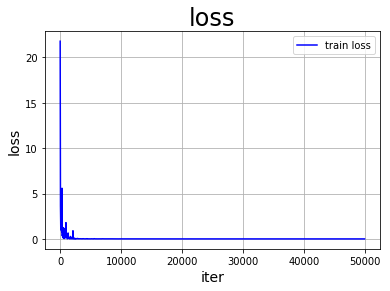

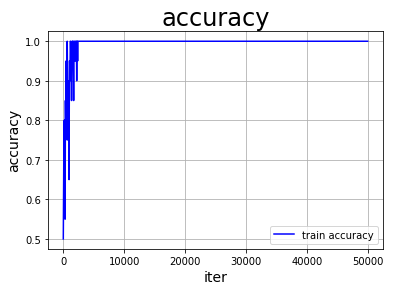

0fold0model训练完成,第0共6
本模型受试者个数6,训练样本shape： (14400, 160)


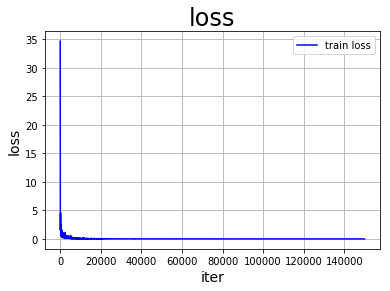

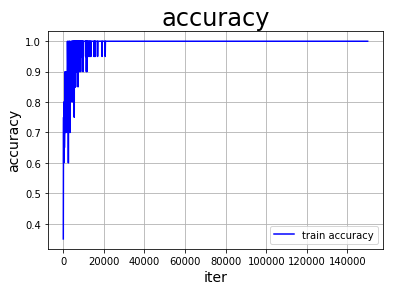

0fold1model训练完成,第1共6
本模型受试者个数4,训练样本shape： (9600, 160)


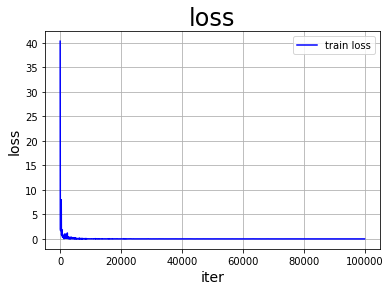

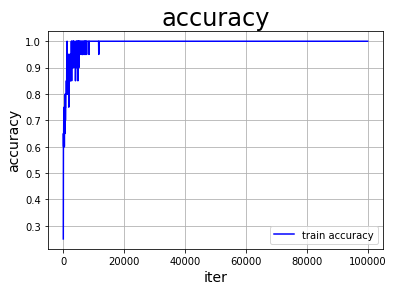

0fold2model训练完成,第2共6
本模型受试者个数5,训练样本shape： (12000, 160)


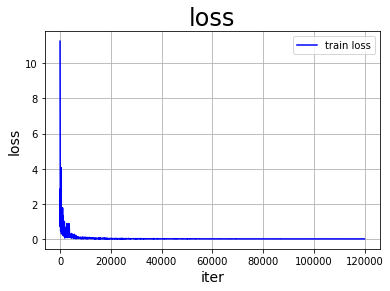

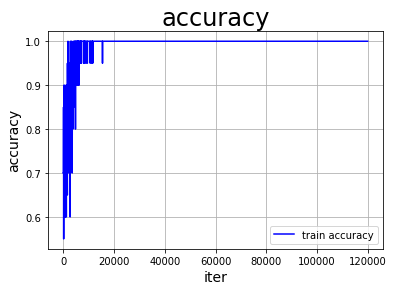

0fold3model训练完成,第3共6
本模型受试者个数3,训练样本shape： (7200, 160)


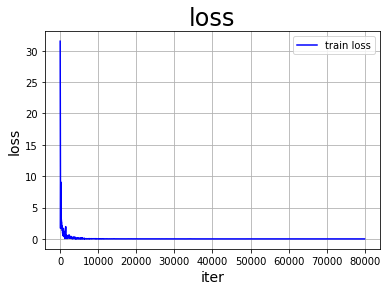

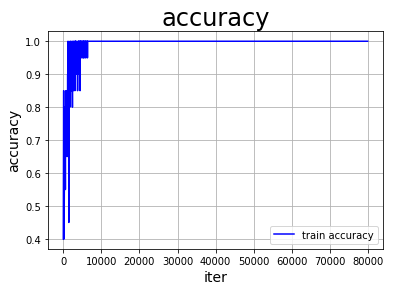

0fold4model训练完成,第4共6
本模型受试者个数4,训练样本shape： (9600, 160)


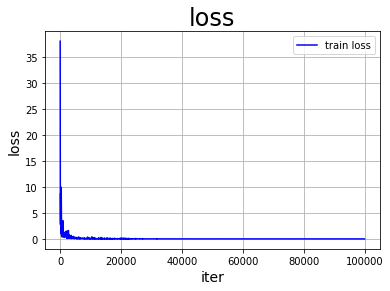

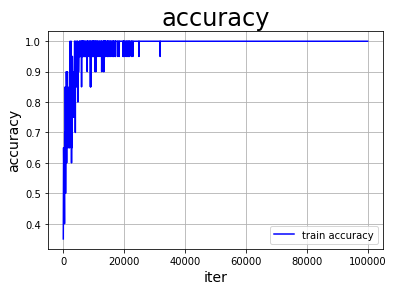

0fold5model训练完成,第5共6
本模型受试者个数4,训练样本shape： (9600, 160)


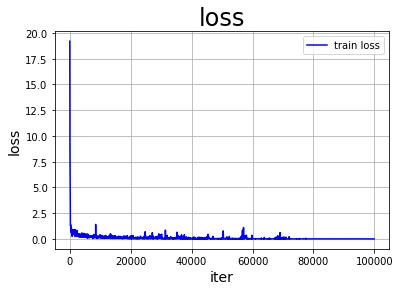

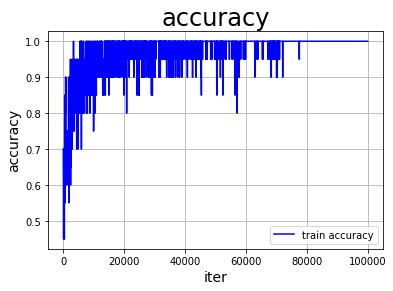

0fold6model训练完成,第6共6
受试者0使用第3个模型进行测试
第0个受试者，loss=[2.2826624], acc=[0.4675]
受试者1使用第6个模型进行测试
第1个受试者，loss=[6.0223737], acc=[0.435]
受试者2使用第1个模型进行测试
第2个受试者，loss=[8.293425], acc=[0.54083335]
受试者3使用第6个模型进行测试
第3个受试者，loss=[6.5288134], acc=[0.4975]
第1折交叉验证开始
本次分组情况: [[20, 26, 15, 28], [17, 18, 29, 14, 2, 9], [11, 27, 16], [25, 31, 13, 8], [19, 30, 22, 0, 12], [1, 24, 23, 3, 10, 21]]
本模型受试者个数4,训练样本shape： (9600, 160)


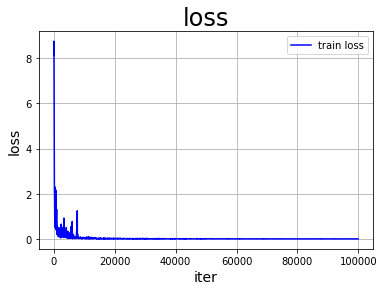

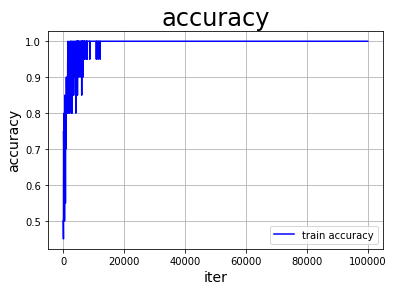

1fold0model训练完成,第0共5
本模型受试者个数6,训练样本shape： (14400, 160)


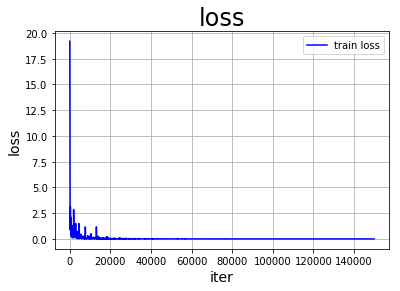

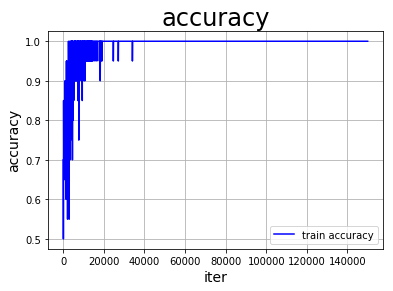

1fold1model训练完成,第1共5
本模型受试者个数3,训练样本shape： (7200, 160)


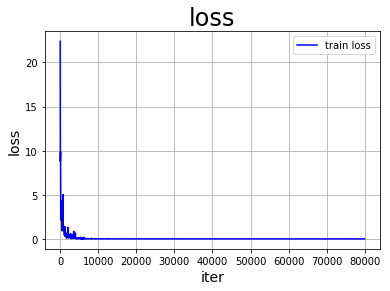

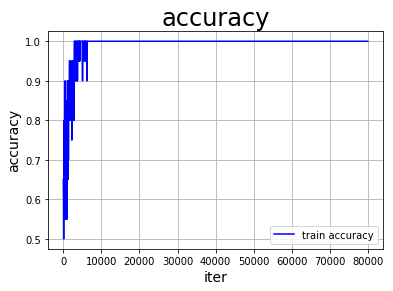

1fold2model训练完成,第2共5
本模型受试者个数4,训练样本shape： (9600, 160)


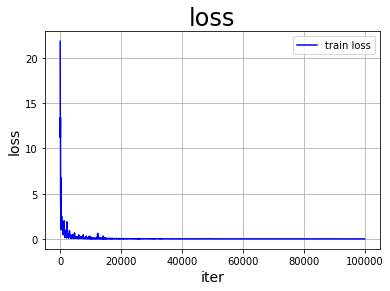

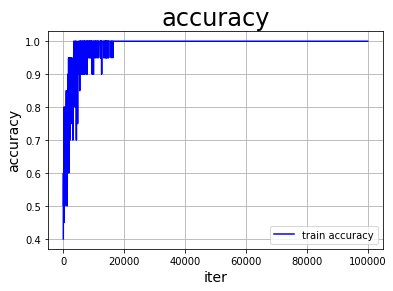

1fold3model训练完成,第3共5
本模型受试者个数5,训练样本shape： (12000, 160)


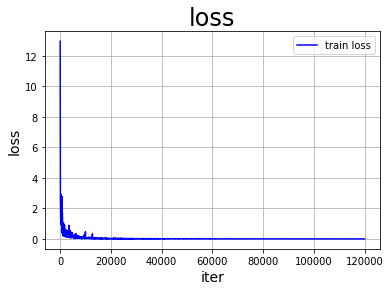

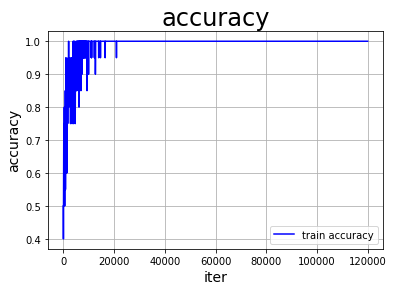

1fold4model训练完成,第4共5
本模型受试者个数6,训练样本shape： (14400, 160)


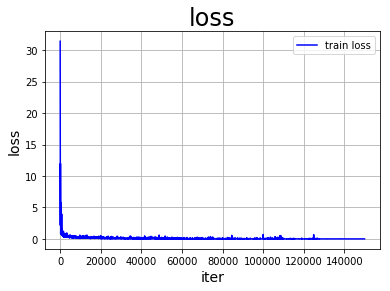

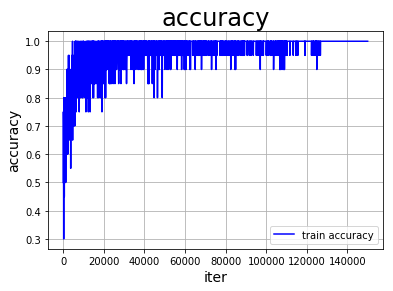

1fold5model训练完成,第5共5
受试者4使用第1个模型进行测试
第4个受试者，loss=[4.3217154], acc=[0.5629167]
受试者5使用第4个模型进行测试
第5个受试者，loss=[4.9832635], acc=[0.57208335]
受试者6使用第4个模型进行测试
第6个受试者，loss=[3.990599], acc=[0.57875]
受试者7使用第4个模型进行测试
第7个受试者，loss=[6.9169517], acc=[0.545]
第2折交叉验证开始
本次分组情况: [[7, 19, 27], [4, 18, 17, 29, 14, 2], [20, 26, 15, 28], [6, 30, 5, 22, 0, 16, 12], [25, 31, 13], [1, 24, 23, 3, 21]]
本模型受试者个数3,训练样本shape： (7200, 160)


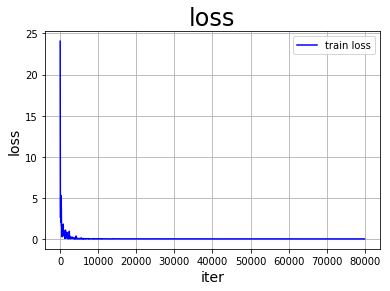

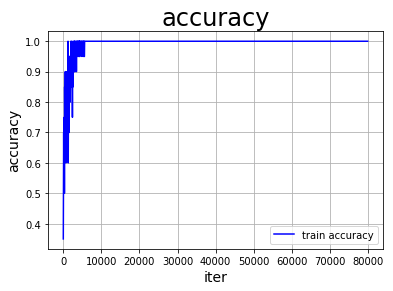

2fold0model训练完成,第0共5
本模型受试者个数6,训练样本shape： (14400, 160)


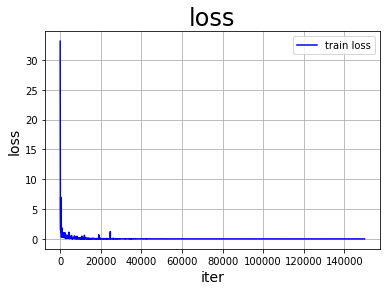

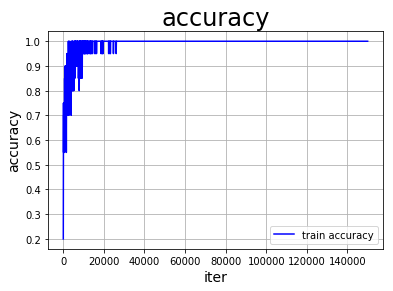

2fold1model训练完成,第1共5
本模型受试者个数4,训练样本shape： (9600, 160)


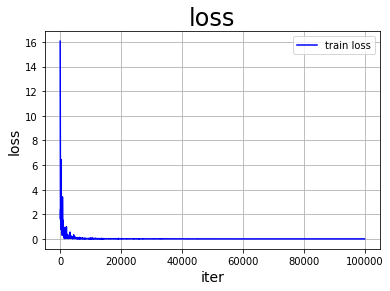

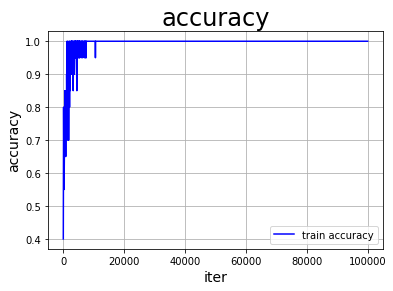

2fold2model训练完成,第2共5
本模型受试者个数7,训练样本shape： (16800, 160)


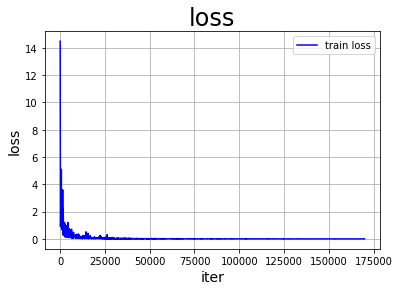

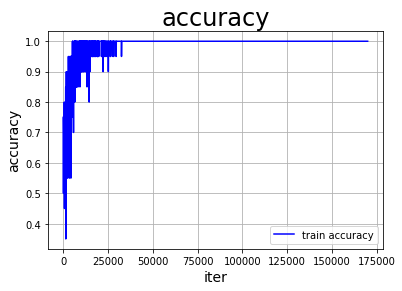

2fold3model训练完成,第3共5
本模型受试者个数3,训练样本shape： (7200, 160)


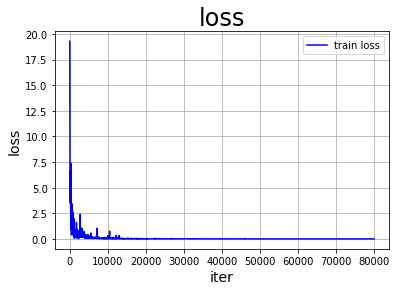

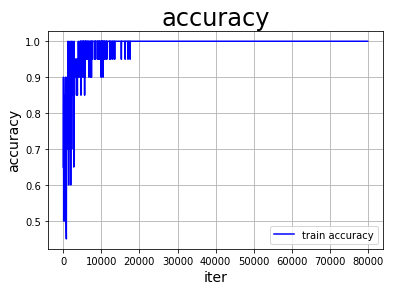

2fold4model训练完成,第4共5
本模型受试者个数5,训练样本shape： (12000, 160)


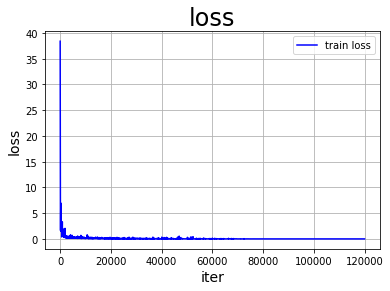

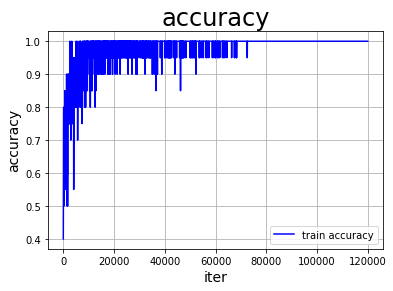

2fold5model训练完成,第5共5
受试者8使用第4个模型进行测试
第8个受试者，loss=[4.587957], acc=[0.53875]
受试者9使用第1个模型进行测试
第9个受试者，loss=[13.655168], acc=[0.5]
受试者10使用第5个模型进行测试
第10个受试者，loss=[6.4274974], acc=[0.4825]
受试者11使用第0个模型进行测试
第11个受试者，loss=[5.2943497], acc=[0.51166666]
第3折交叉验证开始
本次分组情况: [[7, 19], [4, 18, 17, 29], [20, 26, 28], [6, 30, 5, 22, 0], [11, 27, 16], [25, 31, 8], [2, 9], [1, 24, 23, 3, 10, 21]]
本模型受试者个数2,训练样本shape： (4800, 160)


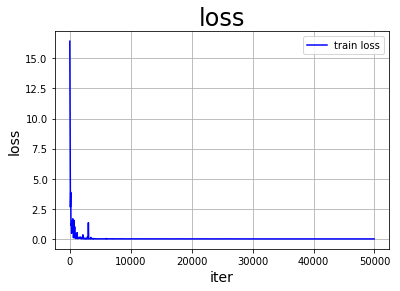

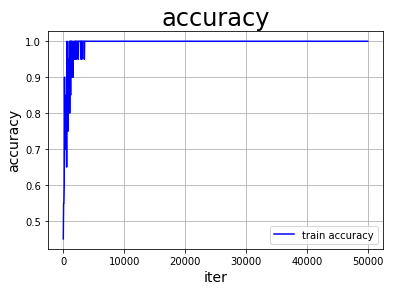

3fold0model训练完成,第0共7
本模型受试者个数4,训练样本shape： (9600, 160)


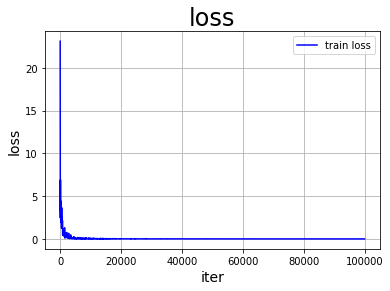

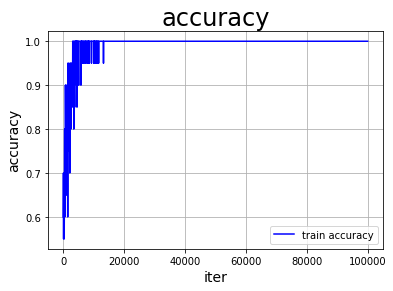

3fold1model训练完成,第1共7
本模型受试者个数3,训练样本shape： (7200, 160)


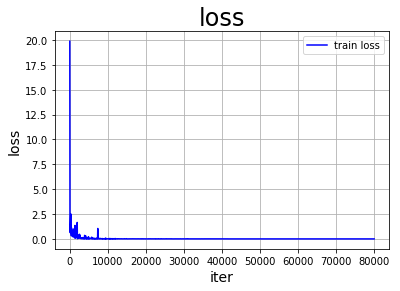

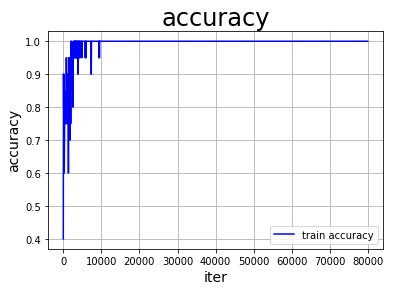

3fold2model训练完成,第2共7
本模型受试者个数5,训练样本shape： (12000, 160)


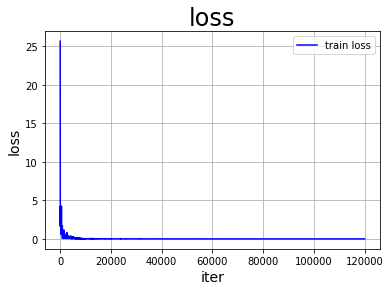

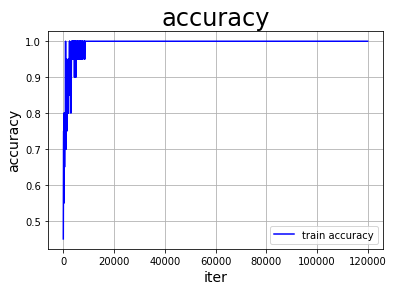

3fold3model训练完成,第3共7
本模型受试者个数3,训练样本shape： (7200, 160)


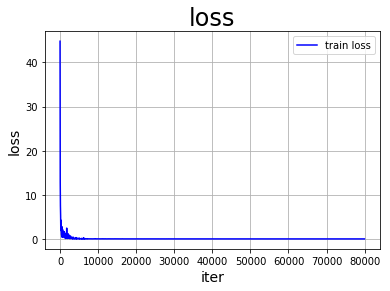

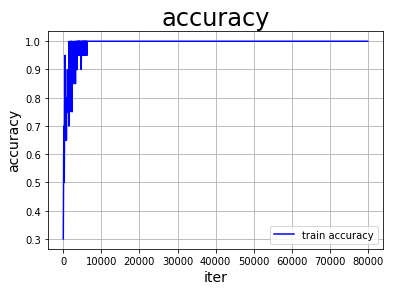

3fold4model训练完成,第4共7
本模型受试者个数3,训练样本shape： (7200, 160)


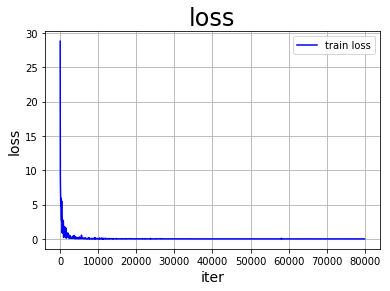

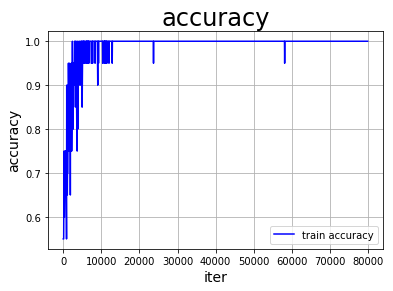

3fold5model训练完成,第5共7
本模型受试者个数2,训练样本shape： (4800, 160)


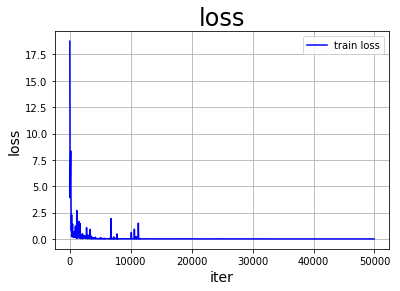

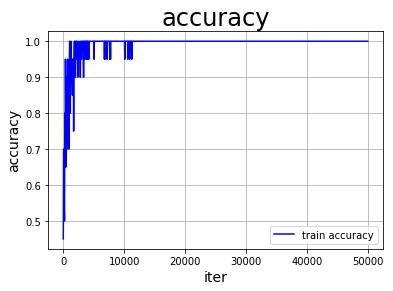

3fold6model训练完成,第6共7
本模型受试者个数6,训练样本shape： (14400, 160)


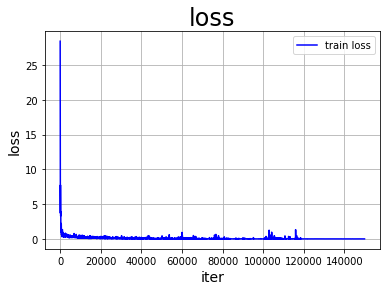

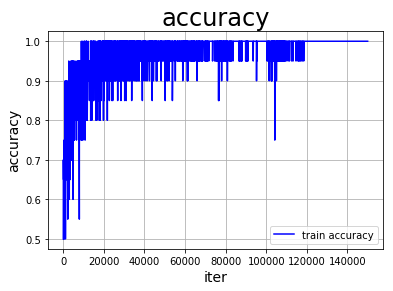

3fold7model训练完成,第7共7
受试者12使用第3个模型进行测试
第12个受试者，loss=[6.399604], acc=[0.50125]
受试者13使用第5个模型进行测试
第13个受试者，loss=[4.295591], acc=[0.51]
受试者14使用第1个模型进行测试
第14个受试者，loss=[10.246646], acc=[0.49291667]
受试者15使用第2个模型进行测试
第15个受试者，loss=[4.850865], acc=[0.57375]
第4折交叉验证开始
本次分组情况: [[20, 26, 15, 28], [6, 30, 5, 7, 22, 0, 12], [4, 29, 14, 2, 9], [11, 27], [25, 31, 13, 8], [1, 24, 23, 3, 10, 21]]
本模型受试者个数4,训练样本shape： (9600, 160)


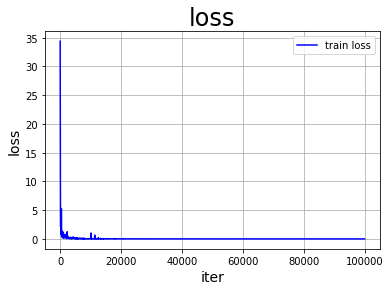

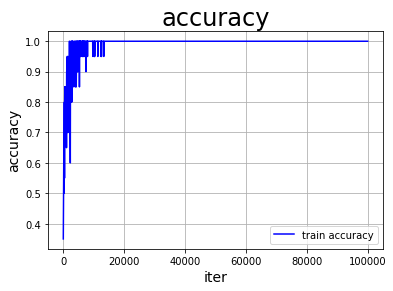

4fold0model训练完成,第0共5
本模型受试者个数7,训练样本shape： (16800, 160)


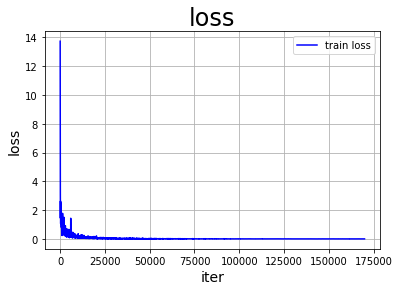

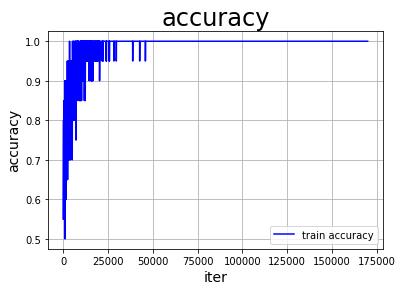

4fold1model训练完成,第1共5
本模型受试者个数5,训练样本shape： (12000, 160)


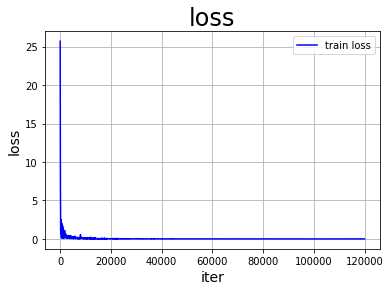

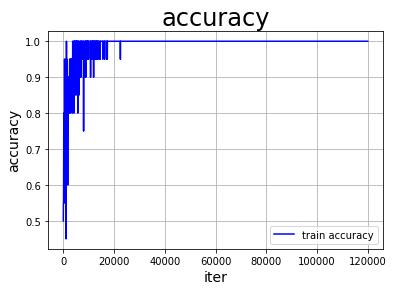

4fold2model训练完成,第2共5
本模型受试者个数2,训练样本shape： (4800, 160)


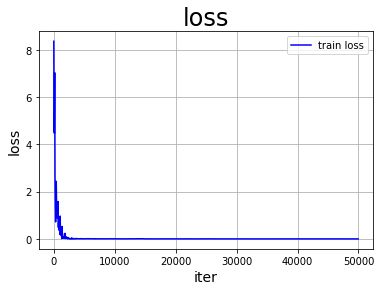

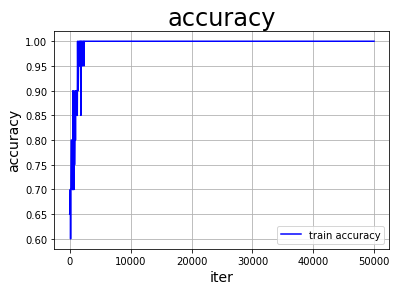

4fold3model训练完成,第3共5
本模型受试者个数4,训练样本shape： (9600, 160)


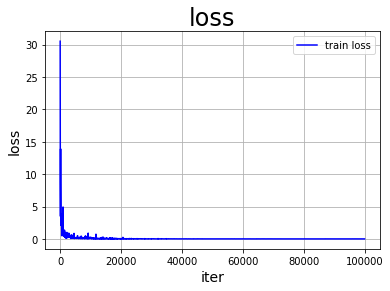

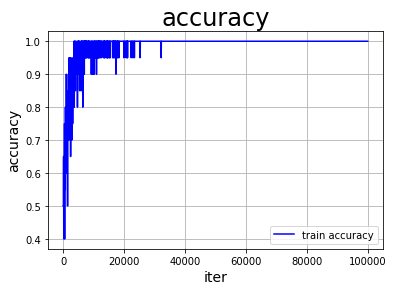

4fold4model训练完成,第4共5
本模型受试者个数6,训练样本shape： (14400, 160)


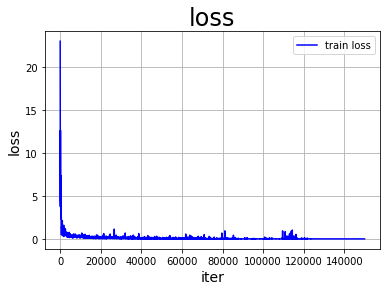

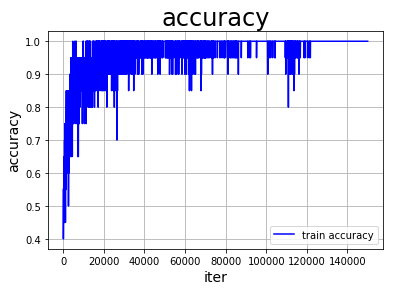

4fold5model训练完成,第5共5
受试者16使用第3个模型进行测试
第16个受试者，loss=[8.245175], acc=[0.56416667]
受试者17使用第2个模型进行测试
第17个受试者，loss=[4.7898893], acc=[0.46833333]
受试者18使用第2个模型进行测试
第18个受试者，loss=[6.658691], acc=[0.47833332]
受试者19使用第1个模型进行测试
第19个受试者，loss=[3.5531836], acc=[0.5308333]
第5折交叉验证开始
本次分组情况: [[7, 19], [4, 18, 17, 29, 14, 2, 9], [6, 30, 5, 0, 12], [11, 27, 16], [25, 31, 13, 8], [15, 26, 28], [1, 24, 3, 10]]
本模型受试者个数2,训练样本shape： (4800, 160)


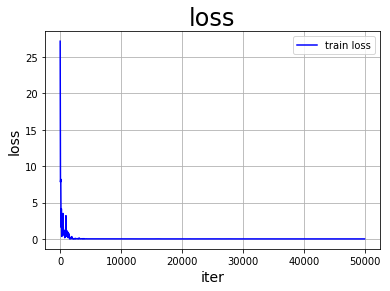

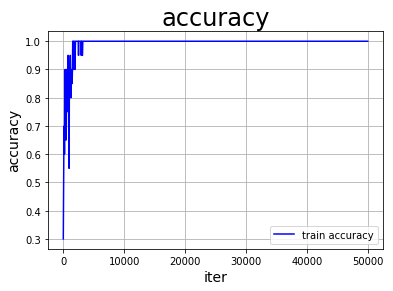

5fold0model训练完成,第0共6
本模型受试者个数7,训练样本shape： (16800, 160)


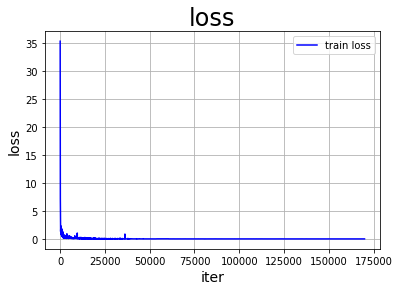

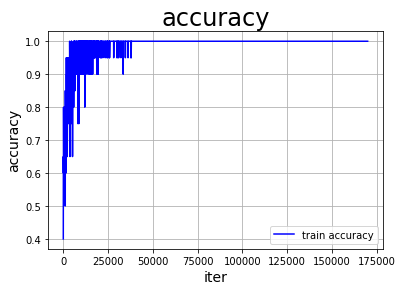

5fold1model训练完成,第1共6
本模型受试者个数5,训练样本shape： (12000, 160)


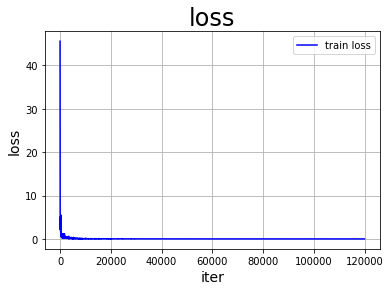

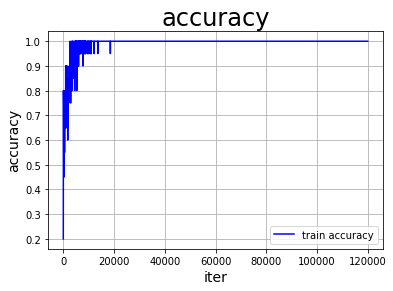

5fold2model训练完成,第2共6
本模型受试者个数3,训练样本shape： (7200, 160)


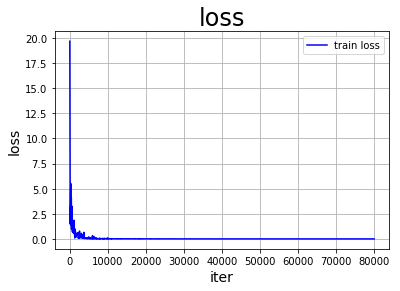

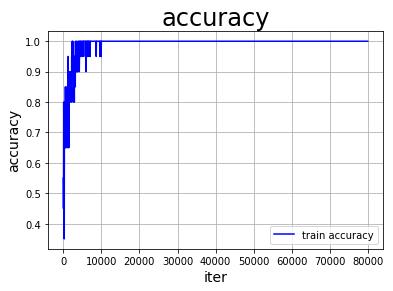

5fold3model训练完成,第3共6
本模型受试者个数4,训练样本shape： (9600, 160)


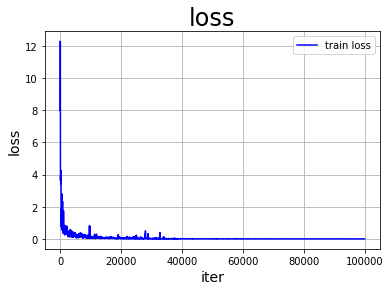

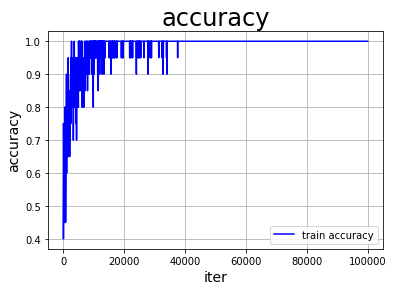

5fold4model训练完成,第4共6
本模型受试者个数3,训练样本shape： (7200, 160)


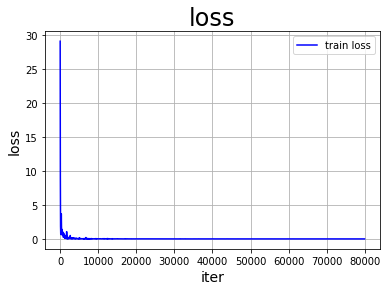

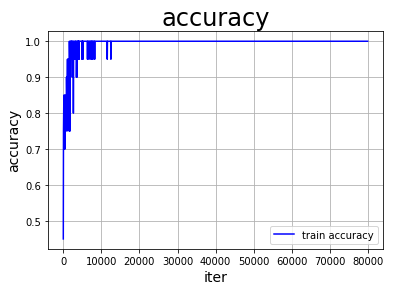

5fold5model训练完成,第5共6
本模型受试者个数4,训练样本shape： (9600, 160)


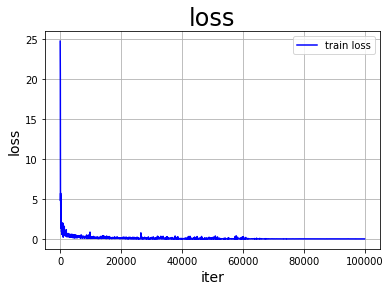

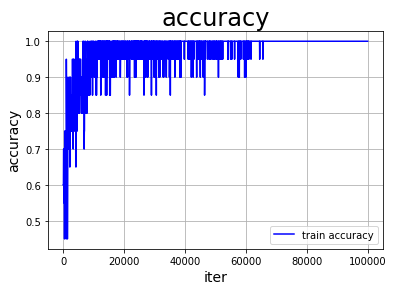

5fold6model训练完成,第6共6
受试者20使用第5个模型进行测试
第20个受试者，loss=[13.455893], acc=[0.5341667]
受试者21使用第6个模型进行测试
第21个受试者，loss=[15.181841], acc=[0.55583334]
受试者22使用第2个模型进行测试
第22个受试者，loss=[4.8732414], acc=[0.5629167]
受试者23使用第6个模型进行测试
第23个受试者，loss=[8.636434], acc=[0.45833334]
第6折交叉验证开始
本次分组情况: [[7, 19, 11, 16], [4, 18, 17, 29, 14, 2, 9, 28], [15, 20, 31, 13, 8], [6, 30, 5, 22, 0, 12], [1, 23, 3, 10, 21]]
本模型受试者个数4,训练样本shape： (9600, 160)


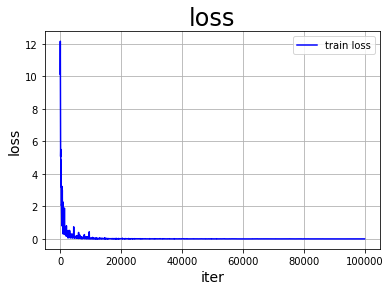

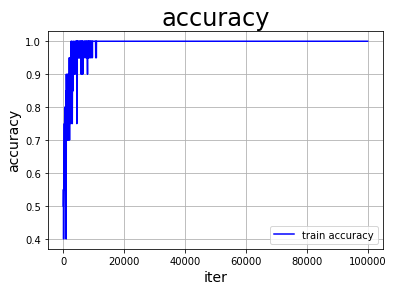

6fold0model训练完成,第0共4
本模型受试者个数8,训练样本shape： (19200, 160)


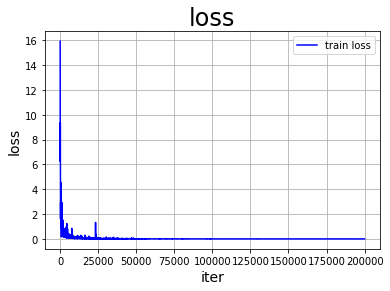

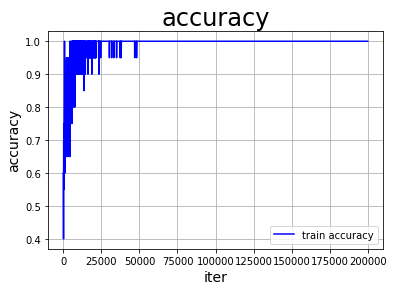

6fold1model训练完成,第1共4
本模型受试者个数5,训练样本shape： (12000, 160)


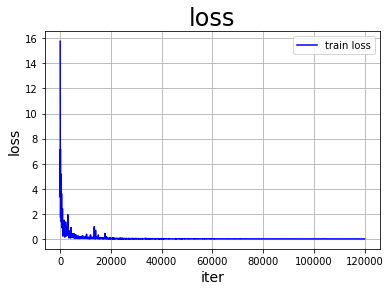

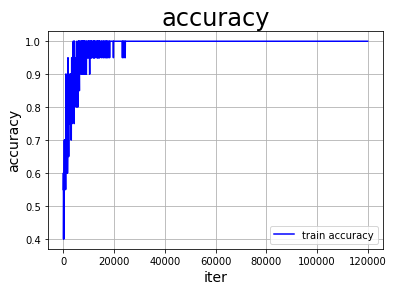

6fold2model训练完成,第2共4
本模型受试者个数6,训练样本shape： (14400, 160)


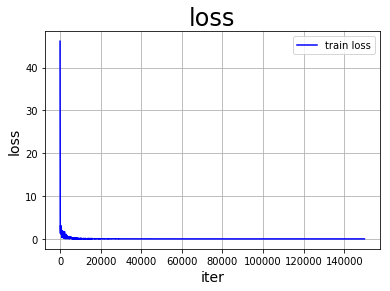

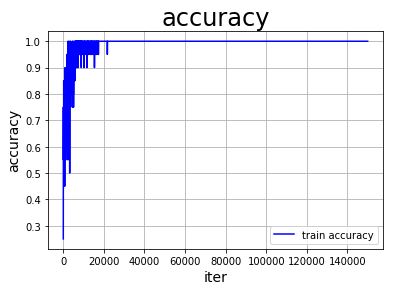

6fold3model训练完成,第3共4
本模型受试者个数5,训练样本shape： (12000, 160)


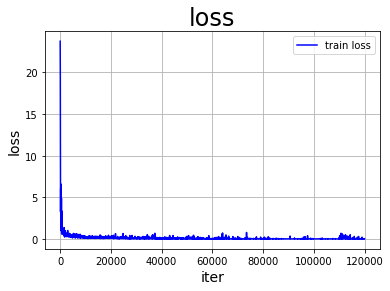

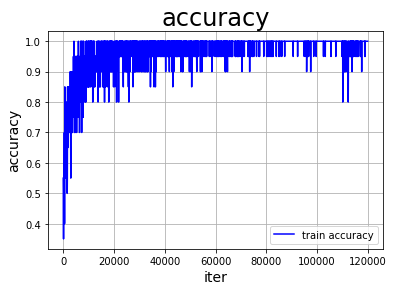

6fold4model训练完成,第4共4
受试者24使用第4个模型进行测试
第24个受试者，loss=[5.204044], acc=[0.5054167]
受试者25使用第2个模型进行测试
第25个受试者，loss=[6.7155914], acc=[0.4775]
受试者26使用第2个模型进行测试
第26个受试者，loss=[1.1972852], acc=[0.61083335]
受试者27使用第0个模型进行测试
第27个受试者，loss=[5.9628367], acc=[0.52708334]
第7折交叉验证开始
本次分组情况: [[7, 19, 5, 6, 12], [4, 18, 17, 14, 2, 9], [20, 26, 15], [11, 27, 16], [0, 22], [13, 25, 8], [1, 24, 23, 3, 10, 21]]
本模型受试者个数5,训练样本shape： (12000, 160)


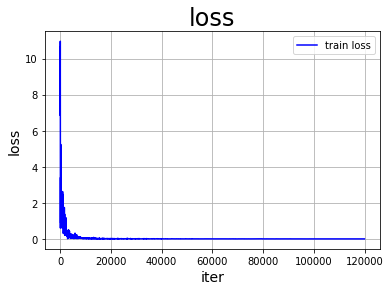

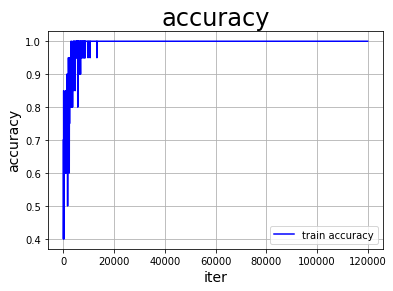

7fold0model训练完成,第0共6
本模型受试者个数6,训练样本shape： (14400, 160)


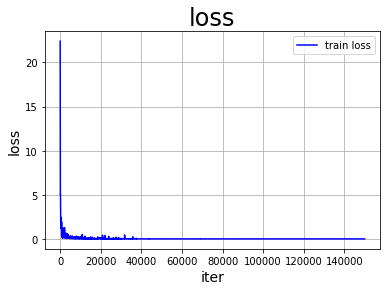

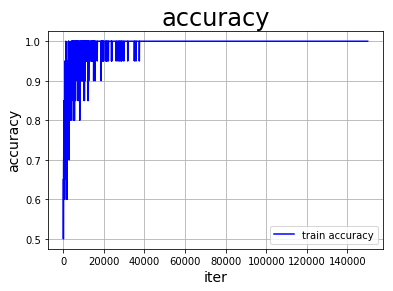

7fold1model训练完成,第1共6
本模型受试者个数3,训练样本shape： (7200, 160)


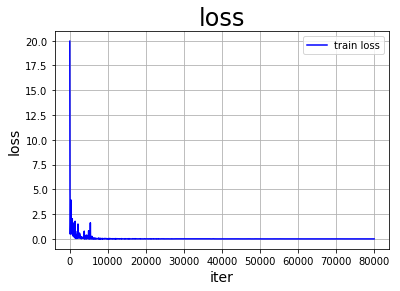

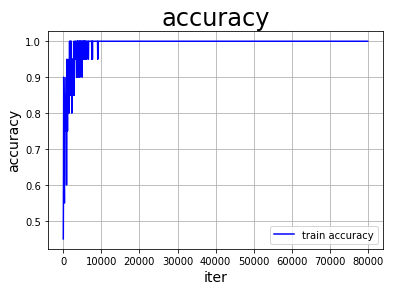

7fold2model训练完成,第2共6
本模型受试者个数3,训练样本shape： (7200, 160)


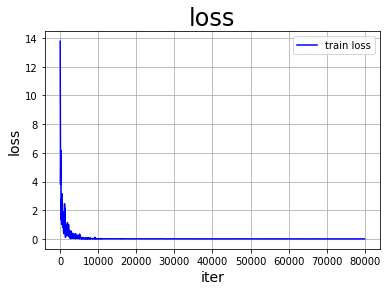

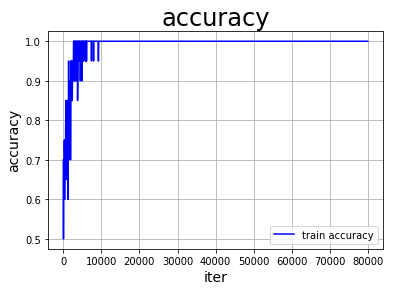

7fold3model训练完成,第3共6
本模型受试者个数2,训练样本shape： (4800, 160)


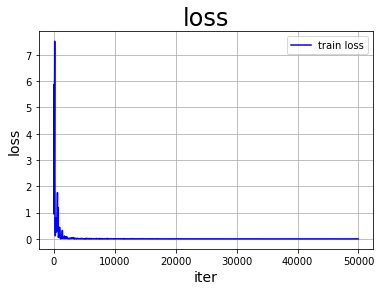

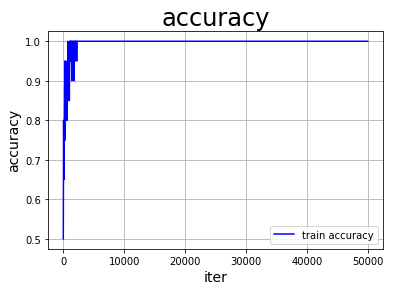

7fold4model训练完成,第4共6
本模型受试者个数3,训练样本shape： (7200, 160)


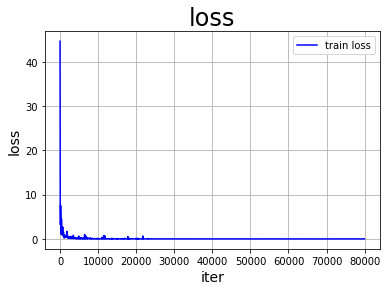

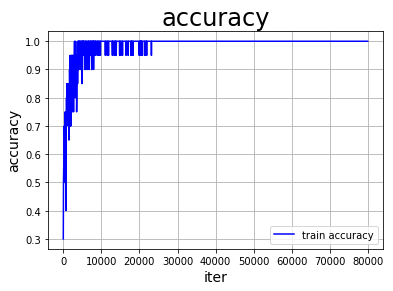

7fold5model训练完成,第5共6
本模型受试者个数6,训练样本shape： (14400, 160)


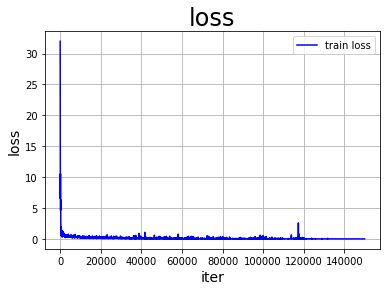

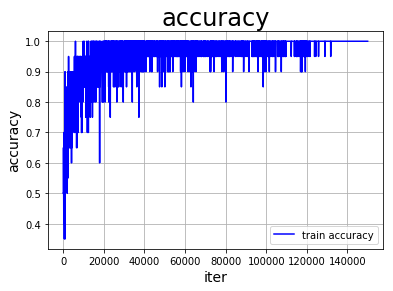

7fold6model训练完成,第6共6
受试者28使用第2个模型进行测试
第28个受试者，loss=[5.377609], acc=[0.56041664]
受试者29使用第1个模型进行测试
第29个受试者，loss=[4.2732787], acc=[0.49541667]
受试者30使用第0个模型进行测试
第30个受试者，loss=[5.988126], acc=[0.44375]
受试者31使用第5个模型进行测试
第31个受试者，loss=[4.2976255], acc=[0.45166665]


In [15]:
valence_or_arousal = -2    #-2 : valence;-1 : arousal
fold8CV_classList = []
#meanAcc = 0
subList = [i for i in range(32)]

for i in range(8):
    print('第{}折交叉验证开始'.format(i))
    testList = subList[i * 4 : (i + 1) * 4]
    trainList = list(set(subList) - set(testList))
    classList = huffman(trainList)
    print('本次分组情况:',classList)
    fold8CV_classList.append(classList)
    for j in range(len(classList)):
        #trainModel(np.array(classList[j]), valence_or_arousal, epoch = 500)[0]
        trainModel(np.array(classList[j]), valence_or_arousal, epoch = 200,fold = i,modelId = j)
        print('{}fold{}model训练完成,第{}共{}'.format(i,j,j,len(classList)-1))
    #break

    subTest(testList, trainList, valence_or_arousal, classList, i)

